# Classification results visualization

Import packages

In [ ]:
import io
import mne
import copy
import glob
import array
import matplotlib
import numpy as np
import pandas as pd
import sklearn.metrics
import seaborn as sns
import scipy.io as sio
import plotly.express as px
import matplotlib.pyplot as plt


from itertools import chain
from sklearn.svm import SVC
from scipy.io import loadmat
from sklearn import set_config

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import permutation_test_score

from mne.time_frequency import tfr_morlet

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, RepeatedStratifiedKFold
from sklearn.utils import resample

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
import matplotlib.lines as lines
from mne.preprocessing import Xdawn
from mne.decoding import Vectorizer

from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA, FastICA

from scipy import stats

# parameters for plotting
plt.rcParams["figure.figsize"] = (10,7)

import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

## Load data

In [2]:
results_dep_rewp_df = pd.read_pickle("data/sonata_data/results/GNG/depression_rewp_freq_results_t20-t30_01_06_sonata.pkl")
results_dep_frn_df = pd.read_pickle("data/sonata_data/results/GNG/depression_frn_results_freq_t20-t30_01_06_sonata.pkl")
results_anx_rewp_df = pd.read_pickle("data/sonata_data/results/GNG/anxiety_rewp_freq_results_t20-t30_01_06_sonata.pkl")
results_anx_frn_df = pd.read_pickle("data/sonata_data/results/GNG/anxiety_frn_freq_results_t20-t30_01_06_sonata.pkl")

In [578]:
results_dep_rewp_df_lin = pd.read_pickle("data/sonata_data/results/GNG/depression_rewp_freq_results_t20-t30_28_06_sonata_lin.pkl")
results_dep_frn_df_lin = pd.read_pickle("data/sonata_data/results/GNG/depression_frn_results_freq_t20-t30_28_06_sonata_lin.pkl")
results_anx_rewp_df_lin = pd.read_pickle("data/sonata_data/results/GNG/anxiety_rewp_freq_results_t20-t30_28_06_sonata_lin.pkl")
results_anx_frn_df_lin = pd.read_pickle("data/sonata_data/results/GNG/anxiety_frn_freq_results_t20-t30_28_06_sonata_lin.pkl")

In [36]:
rewp_depression_datasets = np.load('data/sonata_data/freq_cropped_raw_data/rewp_depression_delta_theta_data.npy')
frn_depression_datasets = np.load('data/sonata_data/freq_cropped_raw_data/frn_depression_delta_theta_data.npy')
rewp_anxiety_datasets = np.load('data/sonata_data/freq_cropped_raw_data/rewp_anxiety_delta_theta_data.npy')
frn_anxiety_datasets = np.load('data/sonata_data/freq_cropped_raw_data/frn_anxiety_delta_theta_data.npy')

Create dataframe that stores results

In [3]:
data_df = pd.DataFrame()

for dataset in [results_dep_rewp_df, results_dep_frn_df, results_anx_rewp_df, results_anx_frn_df]:
    for index, row in dataset.iterrows():

        metrics = ['mean_test_balanced_accuracy','mean_test_precision', 'mean_test_recall', 'mean_test_roc_auc']

        for metric in metrics:
            band = 'delta' if row.pipeline_name.split("_")[3] == '0' else 'theta'
            model_name = row.pipeline_name.split("_")[0] + ' ' + band
            this_data = pd.DataFrame({
                'model': [model_name],
                'dataset': [row.pipeline_name.split("_")[1]],
                'score': [row[metric]],
                'metric': [metric],
            })

            data_df = pd.concat([data_df,this_data]) 

### Summary of results

Parameters

In [666]:
column_list = [
    'pipeline_name', 
    'train score', 
    'mean_test_balanced_accuracy', 
    'pvalue', 
    'mean_test_roc_auc', 
    'mean_test_recall', 
    'mean_test_precision',
]

In [667]:
round_dict = {
    'train score':2,
    'mean_test_balanced_accuracy':2,
    'pvalue':3,
    'mean_test_roc_auc':2,
    'mean_test_recall':2,
    'mean_test_precision':2,
}

In [668]:
columns_mapper = {
    'train score': 'Train ACC', 
    'mean_test_balanced_accuracy': 'ACC', 
    'pvalue': 'p-value' ,
    'mean_test_roc_auc': 'ROC AUC', 
    'mean_test_recall': 'Recall', 
    'mean_test_precision': 'Precision'
}

#### Depression

In [669]:
depression_results = pd.concat(
    [results_dep_rewp_df_lin, results_dep_frn_df_lin], 
    axis=0, 
    ignore_index=True
)[column_list].round(round_dict).rename(columns=columns_mapper)

display(depression_results)

,pipeline_name,Train ACC,ACC,p-value,ROC AUC,Recall,Precision
0,RewP_Depression_band_0_svc,0.57,0.58,0.038,0.57,0.64,0.58
1,RewP_Depression_band_1_svc,0.52,0.58,0.024,0.52,0.84,0.57
2,FRN_Depression_band_0_svc,0.80,0.56,0.057,0.51,0.68,0.55
3,FRN_Depression_band_1_svc,0.50,0.54,0.190,0.47,0.68,0.54


#### Anxiety

In [670]:
anxiety_results = pd.concat(
    [results_anx_rewp_df_lin, results_anx_frn_df_lin], 
    axis=0, 
    ignore_index=True
)[column_list].round(round_dict).rename(columns=columns_mapper)

display(anxiety_results)

,pipeline_name,Train ACC,ACC,p-value,ROC AUC,Recall,Precision
0,RewP_Anxiety_band_0_svc,0.69,0.58,0.032,0.54,0.72,0.56
1,RewP_Anxiety_band_1_svc,0.69,0.58,0.030,0.61,0.59,0.61
2,FRN_Anxiety_band_0_svc,0.57,0.60,0.015,0.63,0.68,0.60
3,FRN_Anxiety_band_1_svc,0.50,0.52,0.091,0.46,0.05,0.33


Plot results

In [23]:
names_dict = {
    'mean_test_balanced_accuracy': 'ACC',
    'mean_test_precision': 'precision',
    'mean_test_roc_auc': 'R_AUC',
    'mean_test_recall': 'recall',
    'RewP delta': 'FP delta',
    'RewP theta': 'FP theta',
    'FRN delta': 'FN delta',
    'FRN theta': 'FN theta',
}

data_df['metric'] = data_df['metric'].replace(names_dict)
data_df['model'] = data_df['model'].replace(names_dict)

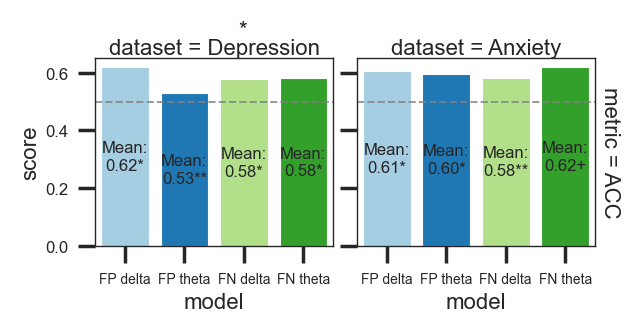

In [52]:
cm = 1/2.54
dpi = 200

plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rc('font', size=6)

sns.set_palette('Paired')
sns.set_style("ticks")

data = data_df[data_df['metric'] == 'ACC']

g = sns.FacetGrid(
    data, 
    col="dataset", 
    row='metric', 
    margin_titles=True,
    # palette = 'dark',
    despine=False,
    sharex = True,
    hue='model',
    aspect=1.3
)

g.map(
    sns.barplot,
    'model',
    'score',
    order=['FP delta', 'FP theta', 'FN delta', 'FN theta'],
    saturation=1,
    linewidth=0.4
)
g.figure.subplots_adjust(wspace=.1, hspace=.05)

axes = g.axes.flatten()

 # add vlines
axes[0].axhline(y=0.5, color='grey', linestyle='--', linewidth = 0.7, alpha=0.8)
axes[1].axhline(y=0.5, color='grey', linestyle='--', linewidth = 0.7, alpha=0.8)
# axes[2].axhline(y=0.5, color='grey', linestyle='--', linewidth = 0.7, alpha=0.8)
# axes[3].axhline(y=0.5, color='grey', linestyle='--', linewidth = 0.7, alpha=0.8)
# axes[4].axhline(y=0.5, color='grey', linestyle='--', linewidth = 0.7, alpha=0.8)
# axes[5].axhline(y=0.5, color='grey', linestyle='--', linewidth = 0.7, alpha=0.8)

# add the annotation

axes[0].bar_label(axes[0].containers[0], fmt='Mean:\n%.2f*', label_type='center')
axes[0].bar_label(axes[0].containers[1], fmt='Mean:\n%.2f**', label_type='center')
axes[0].bar_label(axes[0].containers[2], fmt='Mean:\n%.2f*', label_type='center')
axes[0].bar_label(axes[0].containers[3], fmt='Mean:\n%.2f*', label_type='center')


axes[1].bar_label(axes[1].containers[0], fmt='Mean:\n%.2f*', label_type='center')
axes[1].bar_label(axes[1].containers[1], fmt='Mean:\n%.2f*', label_type='center')
axes[1].bar_label(axes[1].containers[2], fmt='Mean:\n%.2f**', label_type='center')
axes[1].bar_label(axes[1].containers[3], fmt='Mean:\n%.2f+', label_type='center')


# for ax in axes[2:]:
#     ax.bar_label(ax.containers[0], fmt='Mean:\n%.2f', label_type='center')
#     ax.bar_label(ax.containers[1], fmt='Mean:\n%.2f', label_type='center')
#     ax.bar_label(ax.containers[2], fmt='Mean:\n%.2f', label_type='center')
#     ax.bar_label(ax.containers[3], fmt='Mean:\n%.2f', label_type='center')


# for ax in axes:
#     ax.add_artist(lines.Line2D([1, 2], [0.7, 0.7], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([1, 3], [0.75, 0.75], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([0, 2], [0.8, 0.8], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([0, 3], [0.85, 0.85], color='black', linewidth=0.7))
    
#     ax.add_artist(lines.Line2D([1, 1], [0.685, 0.71], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([2, 2], [0.685, 0.71], color='black', linewidth=0.7))

#     ax.add_artist(lines.Line2D([3, 3], [0.735, 0.76], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([1, 1], [0.735, 0.76], color='black', linewidth=0.7))

        
#     ax.add_artist(lines.Line2D([2, 2], [0.787, 0.81], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([0, 0], [0.787, 0.81], color='black', linewidth=0.7))
    
#     ax.add_artist(lines.Line2D([0, 0], [0.835, 0.86], color='black', linewidth=0.7))
#     ax.add_artist(lines.Line2D([3, 3], [0.835, 0.86], color='black', linewidth=0.7))
    
# add significance markers
# ACC
# axes[0].add_artist(lines.Line2D([1, 2], [0.7, 0.7], color='black', linewidth=0.7))
axes[0].add_artist(lines.Line2D([1, 3], [0.75, 0.75], color='black', linewidth=0.7))

# axes[0].add_artist(lines.Line2D([1, 1], [0.685, 0.71], color='black', linewidth=0.7))
# axes[0].add_artist(lines.Line2D([2, 2], [0.685, 0.71], color='black', linewidth=0.7))

axes[0].add_artist(lines.Line2D([3, 3], [0.735, 0.76], color='black', linewidth=0.7))
axes[0].add_artist(lines.Line2D([1, 1], [0.735, 0.76], color='black', linewidth=0.7))

# axes[0].text(1.45, 0.7, '+', fontsize=6)
axes[0].text(1.9, 0.73, '*', fontsize=8)

# precision
# axes[2].add_artist(lines.Line2D([1, 3], [0.75, 0.75], color='black', linewidth=0.7))

# axes[2].add_artist(lines.Line2D([3, 3], [0.735, 0.76], color='black', linewidth=0.7))
# axes[2].add_artist(lines.Line2D([1, 1], [0.735, 0.76], color='black', linewidth=0.7))

# axes[2].text(1.9, 0.73, '**', fontsize=8)

#recall


fig = g.fig
fig.set_size_inches(7*cm, 3*cm)

## Distributions of 10x10 CV classification metrics

Read models

In [35]:
results_dep_rewp_df = pd.read_pickle("data/sonata_data/results/GNG/depression_rewp_freq_results_t20-t30_01_06_sonata.pkl")
results_dep_frn_df = pd.read_pickle("data/sonata_data/results/GNG/depression_frn_results_freq_t20-t30_01_06_sonata.pkl")
results_anx_rewp_df = pd.read_pickle("data/sonata_data/results/GNG/anxiety_rewp_freq_results_t20-t30_01_06_sonata.pkl")
results_anx_frn_df = pd.read_pickle("data/sonata_data/results/GNG/anxiety_frn_freq_results_t20-t30_01_06_sonata.pkl")

Read eeg data

In [36]:
rewp_depression_datasets = np.load('data/sonata_data/freq_cropped_raw_data/rewp_depression_delta_theta_data.npy')
frn_depression_datasets = np.load('data/sonata_data/freq_cropped_raw_data/frn_depression_delta_theta_data.npy')
rewp_anxiety_datasets = np.load('data/sonata_data/freq_cropped_raw_data/rewp_anxiety_delta_theta_data.npy')
frn_anxiety_datasets = np.load('data/sonata_data/freq_cropped_raw_data/frn_anxiety_delta_theta_data.npy')

Define constants

In [37]:
dep_size = 75
dep_ctrl = 72
anx = 65
anx_ctrl = 66
random_state = 42

#### Calculate 10x10 CV scores

Depression

In [15]:
%%capture
long_data_df = pd.DataFrame()

size = int(len(rewp_depression_datasets[0]) / 2)
print(size)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)
metrics = ['balanced_accuracy', 'roc_auc', 'precision', 'recall']
y = np.array(dep_size * [1] +  dep_ctrl * [0])

for metric in metrics:
    for band in (0,1):
        for estimator, dataset in [(results_dep_rewp_df, rewp_depression_datasets), (results_dep_frn_df,frn_depression_datasets)]:

            cv_scores = cross_val_score(estimator.iloc[band].best_model, dataset[band], y, cv=cv, scoring=metric)
            
            this_band = 'delta' if band == 0 else 'theta'  
            model_name = estimator.iloc[band].pipeline_name.split("_")[0]
            this_data = pd.DataFrame({
                'model': [model_name] * len(cv_scores),
                'dataset': [estimator.iloc[band].pipeline_name.split("_")[1]] * len(cv_scores),
                'band': [this_band] * len(cv_scores),
                'scores': cv_scores,
                'metric': [metric] * len(cv_scores),
            })
    
            long_data_df = pd.concat([long_data_df,this_data]) 

Anxiety

In [18]:
%%capture

size = int(len(rewp_anxiety_datasets[0]) / 2)
print(size)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=random_state)
metrics = ['balanced_accuracy', 'roc_auc', 'precision', 'recall']
y = np.array(anx * [1] +  anx_ctrl * [0])

for metric in metrics:
    for band in (0,1):
        for estimator, dataset in [(results_anx_rewp_df, rewp_anxiety_datasets), (results_anx_frn_df,frn_anxiety_datasets)]:

            cv_scores = cross_val_score(estimator.iloc[band].best_model, dataset[band], y, cv=cv, scoring=metric)
            
            this_band = 'delta' if band == 0 else 'theta'
                
            model_name = estimator.iloc[band].pipeline_name.split("_")[0]
            this_data = pd.DataFrame({
                'model': [model_name] * len(cv_scores),
                'dataset': [estimator.iloc[band].pipeline_name.split("_")[1]] * len(cv_scores),
                'band': [this_band] * len(cv_scores),
                'scores': cv_scores,
                'metric': [metric] * len(cv_scores),
            })
    
            long_data_df = pd.concat([long_data_df,this_data]) 

Summary of the results

In [21]:
long_data_df.groupby(['model', 'dataset', 'band', 'metric']).mean()

scores
model dataset    band  metric                     
FRN   Anxiety    delta balanced_accuracy  0.512619
                       precision          0.519538
                       recall             0.561190
                       roc_auc            0.488129
                 theta balanced_accuracy  0.567857
                       precision          0.589514
                       recall             0.510714
                       roc_auc            0.607143
      Depression delta balanced_accuracy  0.518304
                       precision          0.531790
                       recall             0.551607
                       roc_auc            0.510791
                 theta balanced_accuracy  0.517054
                       precision          0.527781
                       recall             0.499464
                       roc_auc            0.510332
RewP  Anxiety    delta balanced_accuracy  0.525952
                       precision          0.518645
                       recall             0.587143
                       roc_auc            0.505272
                 theta balanced_accuracy  0.491548
                       precision          0.494106
                       recall             0.509048
                       roc_auc            0.472211
      Depression delta balanced_accuracy  0.607054
                       precision          0.619872
                       recall             0.595357
                       roc_auc            0.648724
                 theta balanced_accuracy  0.511607
                       precision          0.526641
                       recall             0.712143
                       roc_auc            0.471071

### Visualize results

Rename items in results dataframe

In [23]:
long_names_dict = {
    'balanced_accuracy': 'ACC',
    'roc_auc': 'R_AUC',
    'RewP': 'reward',
    'FRN': 'punishment',
    'FP': 'reward',
    'FN': 'punishment',
}

long_data_df['metric'] = long_data_df['metric'].replace(long_names_dict)
long_data_df['model'] = long_data_df['model'].replace(long_names_dict)

Plot violinplots

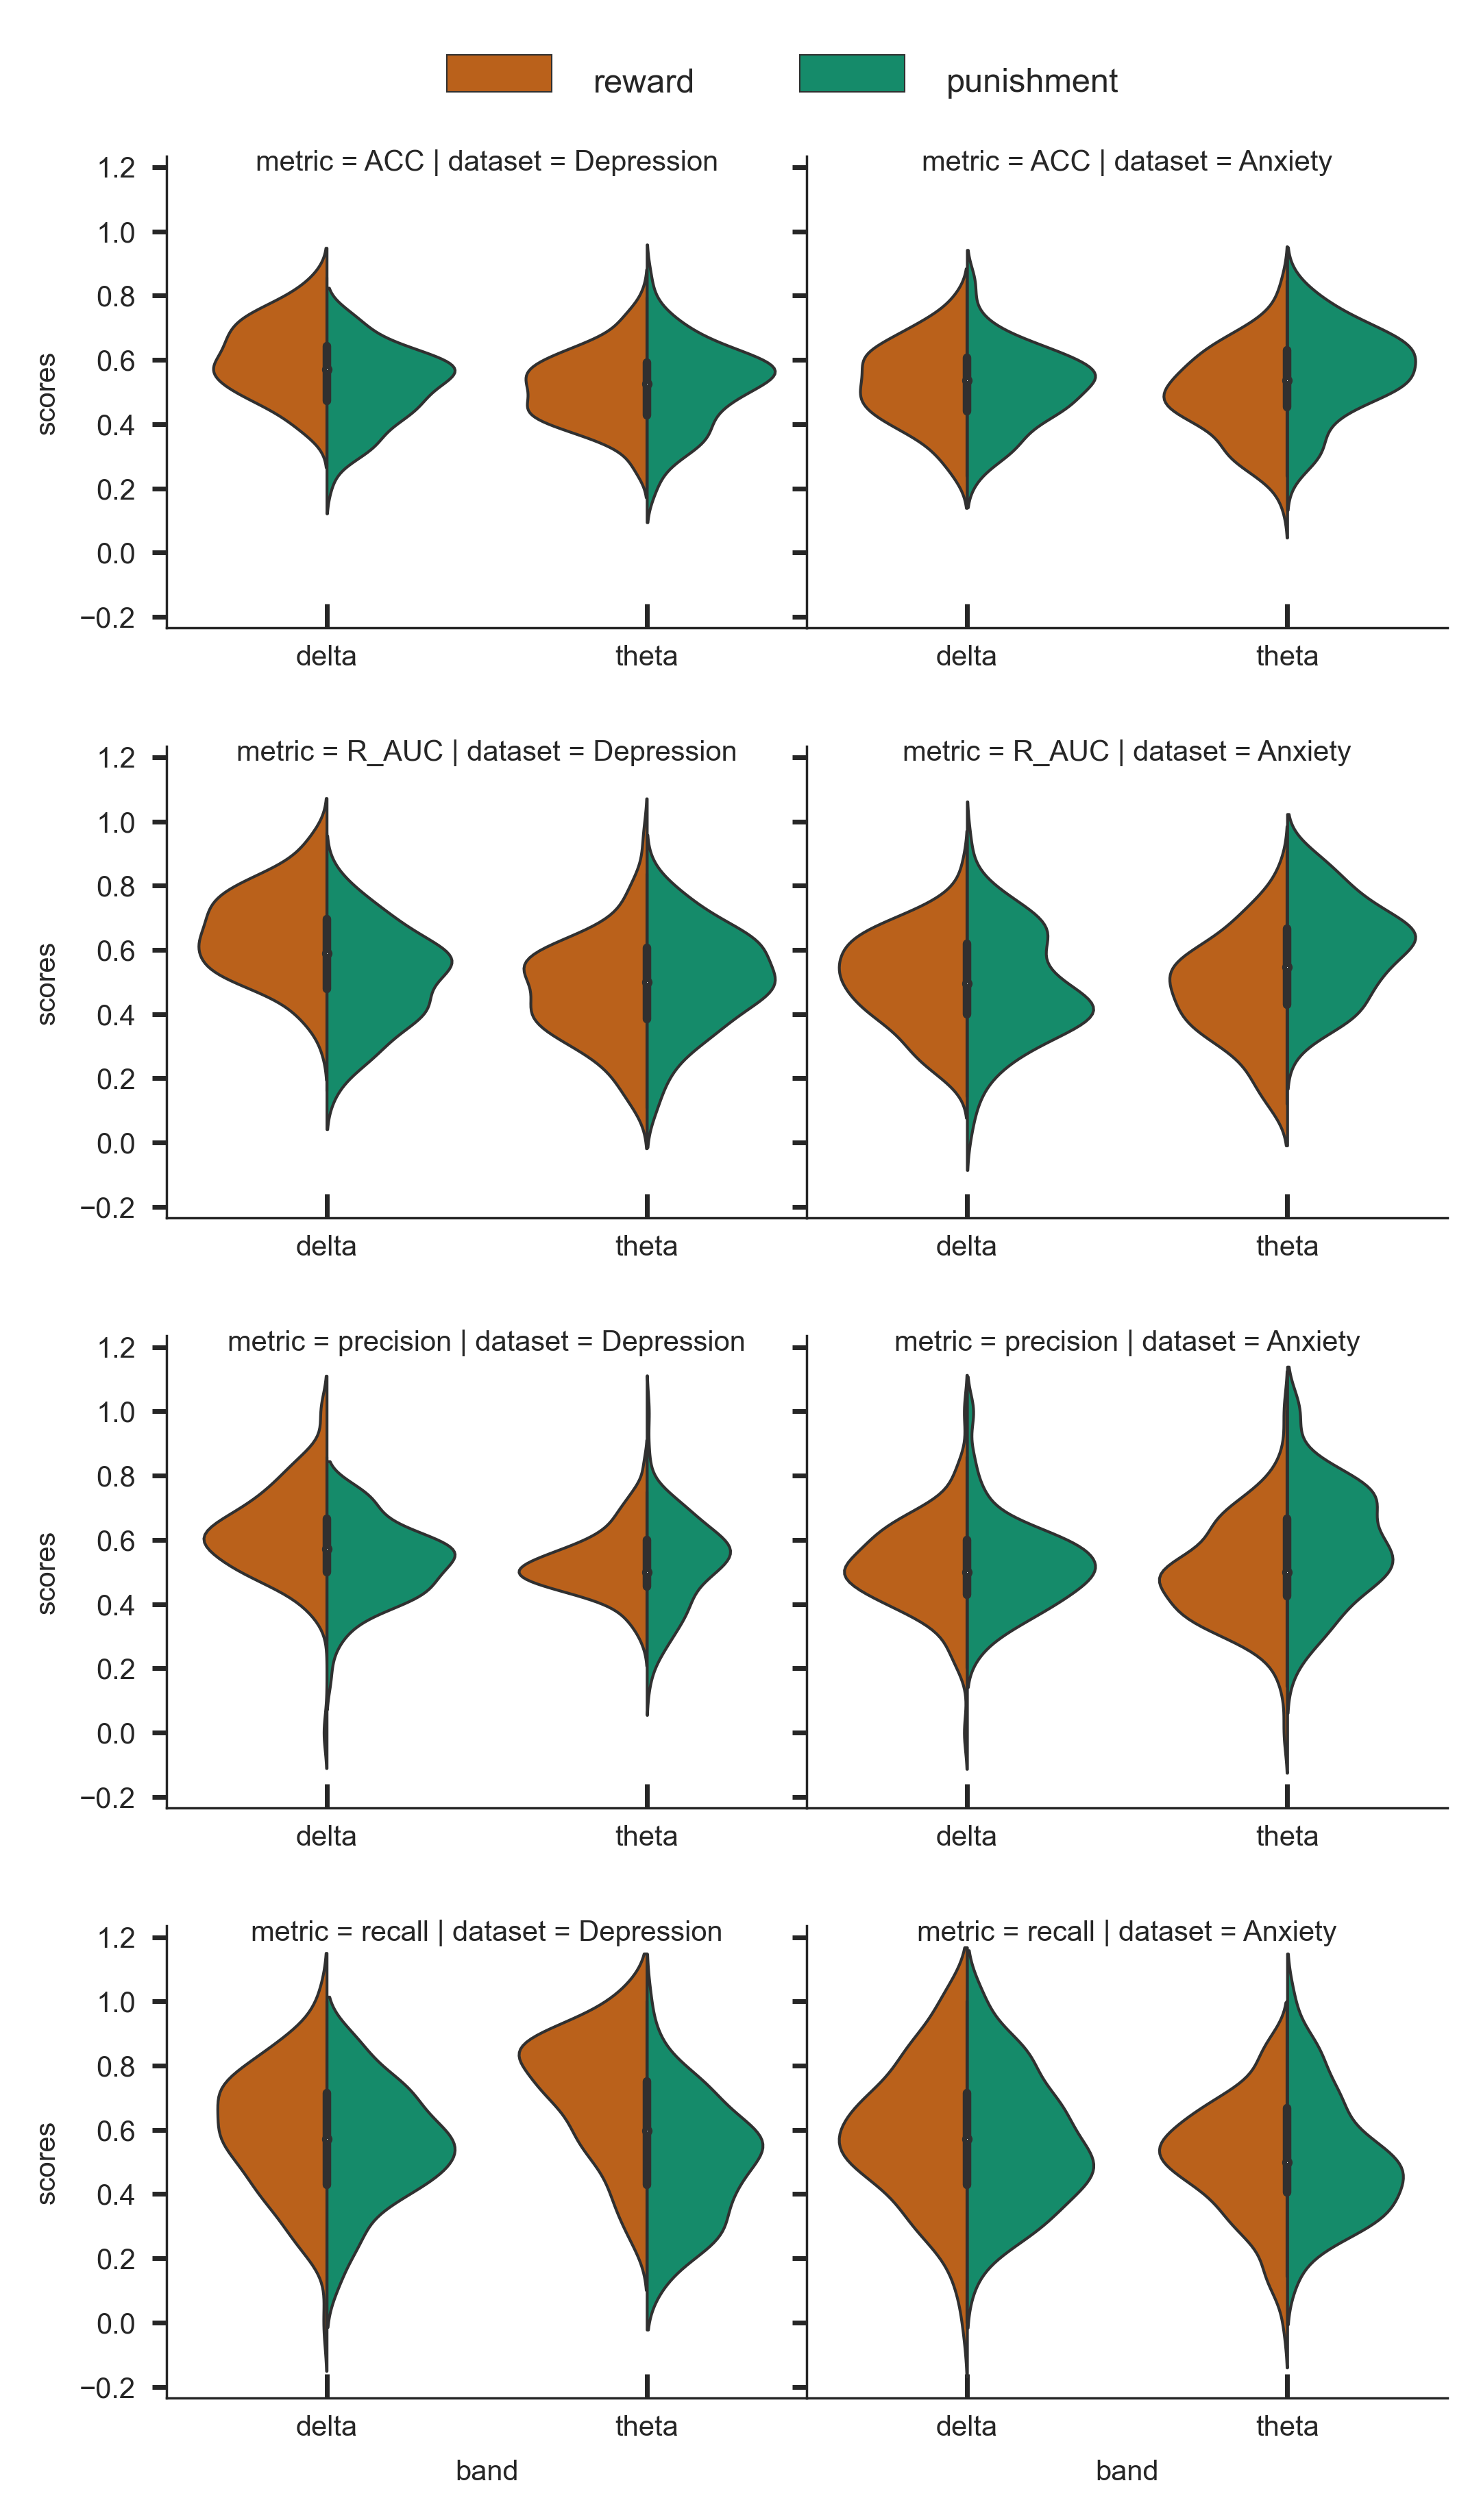

In [57]:
# plot parameters
cm = 1/2.54
dpi = 500

plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -3
plt.rc('font', size=6)
sns.set_style("white")
sns.set_style("ticks")


colors = [sns.color_palette("colorblind")[3], sns.color_palette("colorblind")[2], 'gray']
sns.set_palette(colors)

g = sns.catplot(
    x='band', 
    y='scores', 
    hue='model',
    row='metric', 
    col='dataset', 
    data=long_data_df, 
    kind='violin', 
    height=6,
    split = True,
    despine = False,
    legend_out = False,
    linewidth = 0.6,
    sharex=False,
)

g.figure.subplots_adjust(wspace=.0, hspace=.25)

sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

plt.setp(g._legend.get_texts(), fontsize=7)

fig = g.fig

for ax in fig.axes:
    ax.tick_params(axis='x', direction='in', length=5, width=1)
    ax.tick_params(axis='y', direction='out', length=3, width=1)


fig.set_size_inches(10*cm, 17*cm)

plt.show()

fig.savefig(f'data/figure_3_metric_results/metrics', bbox_inches='tight', pad_inches=0.01)